In [37]:
!pip3 install numpy pandas matplotlib sparqlwrapper

# Data collection

In [ ]:
!pip3 install requests fractions

In [18]:
import requests
import shutil
import os
import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get towers
query = """SELECT DISTINCT ?tower ?towerLabel ?image {
  ?tower wdt:P31 wd:Q12518;
          wdt:P18 ?image.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 100"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["towerLabel"]["value"],
            result["image"]["value"],
        )
    )

dataframe = pd.DataFrame(array, columns=["tower", "image"])
dataframe = dataframe.astype(
    dtype={"tower": "<U200", "image": "<U200"}
)



def download_image(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(os.path.join("images", os.path.basename(url)), "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

dataframe.image.apply(download_image)

0     200
1     200
2     200
3     200
4     200
     ... 
95    200
96    200
97    200
98    200
99    200
Name: image, Length: 100, dtype: int64

# Metadata / Labeling and Annotation

In [27]:
import os
import json
from PIL import Image
from fractions import Fraction
from PIL.ExifTags import TAGS
import numpy as np
from sklearn.cluster import KMeans


# Create the users directory if it doesn't exist
if not os.path.exists('json'):
    os.makedirs('json')

# Clear file content at program start
open("json/image_tags.json", 'w').close()

def get_exif_data(img):
    exif_data = img.getexif()
    exif = {}
    if exif_data:
        for tag, value in exif_data.items():
            if tag in TAGS:
                if isinstance(value, bytes):
                    value = value.decode(errors='ignore')
                elif isinstance(value, (Fraction, int, float)):
                    value = str(value)
                elif isinstance(value, tuple):
                    value = tuple(str(v) for v in value)
                else:
                    value = str(value)
                exif[TAGS[tag]] = value
    return exif

def get_image_metadata(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Ensure image is in RGB mode
    img_size = img.size
    exif_data = get_exif_data(img)
    exif_data.pop('MakerNote', None)
    img = img.resize((100, 100))  # Resize to speed up processing
    img_array = np.array(img)
    img_array = img_array.reshape((img_array.shape[0] * img_array.shape[1], 3))
    
    kmeans = KMeans(n_clusters=5, n_init=10)
    kmeans.fit(img_array)
    
    # Get cluster colors
    main_color = kmeans.cluster_centers_
    metadata = {
        "filename": os.path.basename(image_path),
        "format": img.format,
        "size": img_size,
        "mode": img.mode,
        "orientation": "landscape" if img_size[0] > img_size[1] else "portrait",
        "orientation_id": 0 if img.width > img.height else 1,
        "exif": exif_data,
        "favorite_color": [main_color[i].tolist() for i in np.argsort(main_color.sum(axis=1))],
    }
    return metadata

def save_metadata_to_json(metadata, output_file="json/image_tags.json"):
    try:
        with open(output_file, 'r') as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        data = []

    data.append(metadata)

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

image_files = [f"images/{f}" for f in os.listdir('images') if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
for image_path in image_files:
    metadata = get_image_metadata(image_path)
    save_metadata_to_json(metadata)
    print(f"Image metadata {image_path} saved.")

Image metadata images/Grosshaufmt1p.jpg saved.
Image metadata images/2010-03-23%20Broitzem-TV-Turm.JPG saved.
Image metadata images/Birk%20%28Lohmar%29%20Fernmeldeturm.jpg saved.
Image metadata images/Merkendorf%2C%20Unteres%20Tor-001.jpg saved.
Image metadata images/London%20Lanthorn%20Tower%2008.03.2013%2013-39-42.JPG saved.
Image metadata images/Mannesmann-tower-hannover-messe.jpg saved.
Image metadata images/Trier%20Frankenturm%20BW%201.JPG saved.
Image metadata images/P1000625%20Paris%20IV%20Tour%20Saint-Jacques%20resultwk.JPG saved.
Image metadata images/Bautzen%20M%C3%BChlbastei%202.JPG saved.
Image metadata images/Ln0pZand2.jpg saved.
Image metadata images/D%C3%BClmen%2C%20Nonnenturm%20--%202012%20--%204152.jpg saved.
Image metadata images/2008-05-16%20Handwerkerhof%20N%C3%BCrnberg%20Frauentor.jpg saved.
Image metadata images/Krynice%20%28maszt%29.jpg saved.
Image metadata images/Turm%202%20Koenigstuhl%20Heidelberg.jpg saved.
Image metadata images/Freiherr-vom-Stein-Turm%20%28H

# Data Analysis

In [14]:
import json
import os
import random

# Create the users directory if it doesn't exist
if not os.path.exists('json'):
    os.makedirs('json')

# Get metadata for all images
with open('json/image_tags.json', 'r') as f:
    metadata = json.load(f)

# Get all image filenames
image_filenames = [img['filename'] for img in metadata]

# Create a copy of image_filenames to draw from
available_images = image_filenames.copy()

# Dictionary to hold user data
users_data = {}

# For each user (1 to 5)
for i in range(5):
    # Randomly select 5 unique images for this user
    user_images = random.sample(available_images, 5)
    
    # Remove selected images from available pool
    for img in user_images:
        available_images.remove(img)
    
    # Add user data to dictionary
    users_data[f'user{i+1}'] = {
        'images': user_images,
        # You can add more user-specific information here
        'additional_info': {}
    }

# Save to a single JSON file
with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users_data, f, ensure_ascii=False, indent=2)

print("User file created with 5 unique images each")


User file created with 5 unique images each


## User favorite...

### ...Color

In [21]:
import json
import numpy as np
from sklearn.cluster import KMeans

# Load user data
with open('json/users.json', 'r') as f:
    users_data = json.load(f)

# Load image metadata
with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)

for i in range(1, 6):
    # Get user's images
    user_images = users_data[f'user{i}']['images']

    # Get dominant colors for each user's favorite image
    favorite_color = []
    for image_filename in user_images:
        for img_data in image_metadata:
            if img_data['filename'] == image_filename:
                favorite_color.extend(img_data['favorite_color'])
                break

    # Convert dominant colors to numpy array
    favorite_color = np.array(favorite_color)

    # Use KMeans to find the most present color among dominant colors
    kmeans = KMeans(n_clusters=1, n_init=10)
    kmeans.fit(favorite_color)
    most_present_color = kmeans.cluster_centers_[0]

    # Add dominant color to user's additional information
    users_data[f'user{i}']['additional_info']['favorite_color'] = most_present_color.tolist()

# Save updated data to users.json file
with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users_data, f, ensure_ascii=False, indent=2)

print("Dominant colors added to user information.")


Dominant colors added to user information.


### ...Orientation

In [23]:
import os
import json

# Get metadata for all images
with open('json/image_tags.json', 'r') as f:
    metadata = json.load(f)

# Get users info
with open('json/users.json', 'r') as f:
    users = json.load(f)

for i in range(1, 6):
    sum_orientation = 0
    images = users[f'user{i}']['images']
    for image_data in metadata:
        if image_data['filename'] in images:
            sum_orientation += image_data['orientation_id']
    if sum_orientation > 3:
        users[f'user{i}']['additional_info']['orientation_favorite'] = 'portrait'
    else:
        users[f'user{i}']['additional_info']['orientation_favorite'] = 'landscape'

    

with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users, f, ensure_ascii=False, indent=2)

print("Favorite orientations have been added to user information.")


Favorite orientations have been added to user information.


### ...Size

In [24]:
import json
import numpy as np

# Load image metadata
with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)

# Calculate average image size to determine size categories
sizes = [w * h for img in image_metadata for w, h in [img['size']]]
avg_size = np.mean(sizes)

# Load user data
with open('json/users.json', 'r') as f:
    users = json.load(f)

# Determine size categories based on average size
for i in range(1, 6):
    # Add information about image sizes
    user_images = users[f'user{i}']['images']
    user_sizes = [img_data['size'] for img_data in image_metadata if img_data['filename'] in user_images]
    
    # Determine favorite size
    user_avg_size = np.mean([w * h for w, h in user_sizes])
    if user_avg_size < avg_size * 0.5:
        size_category = 'thumbnail'
    elif user_avg_size < avg_size:
        size_category = 'medium'
    elif user_avg_size < avg_size * 1.5:
        size_category = 'large'
    else:
        size_category = 'very large'
    
    users[f'user{i}']['additional_info']['favorite_size'] = size_category

# Save updated data to users.json file
with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users, f, ensure_ascii=False, indent=2)

print("Favorite sizes have been added to user information.")

Favorite sizes have been added to user information.


# Data visualization

In [20]:
!pip install seaborn

## Trending informations

/tmp/ipykernel_105969/4238500799.py:59: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/matthias/Documents/ProjetDataMining/DM_projet/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


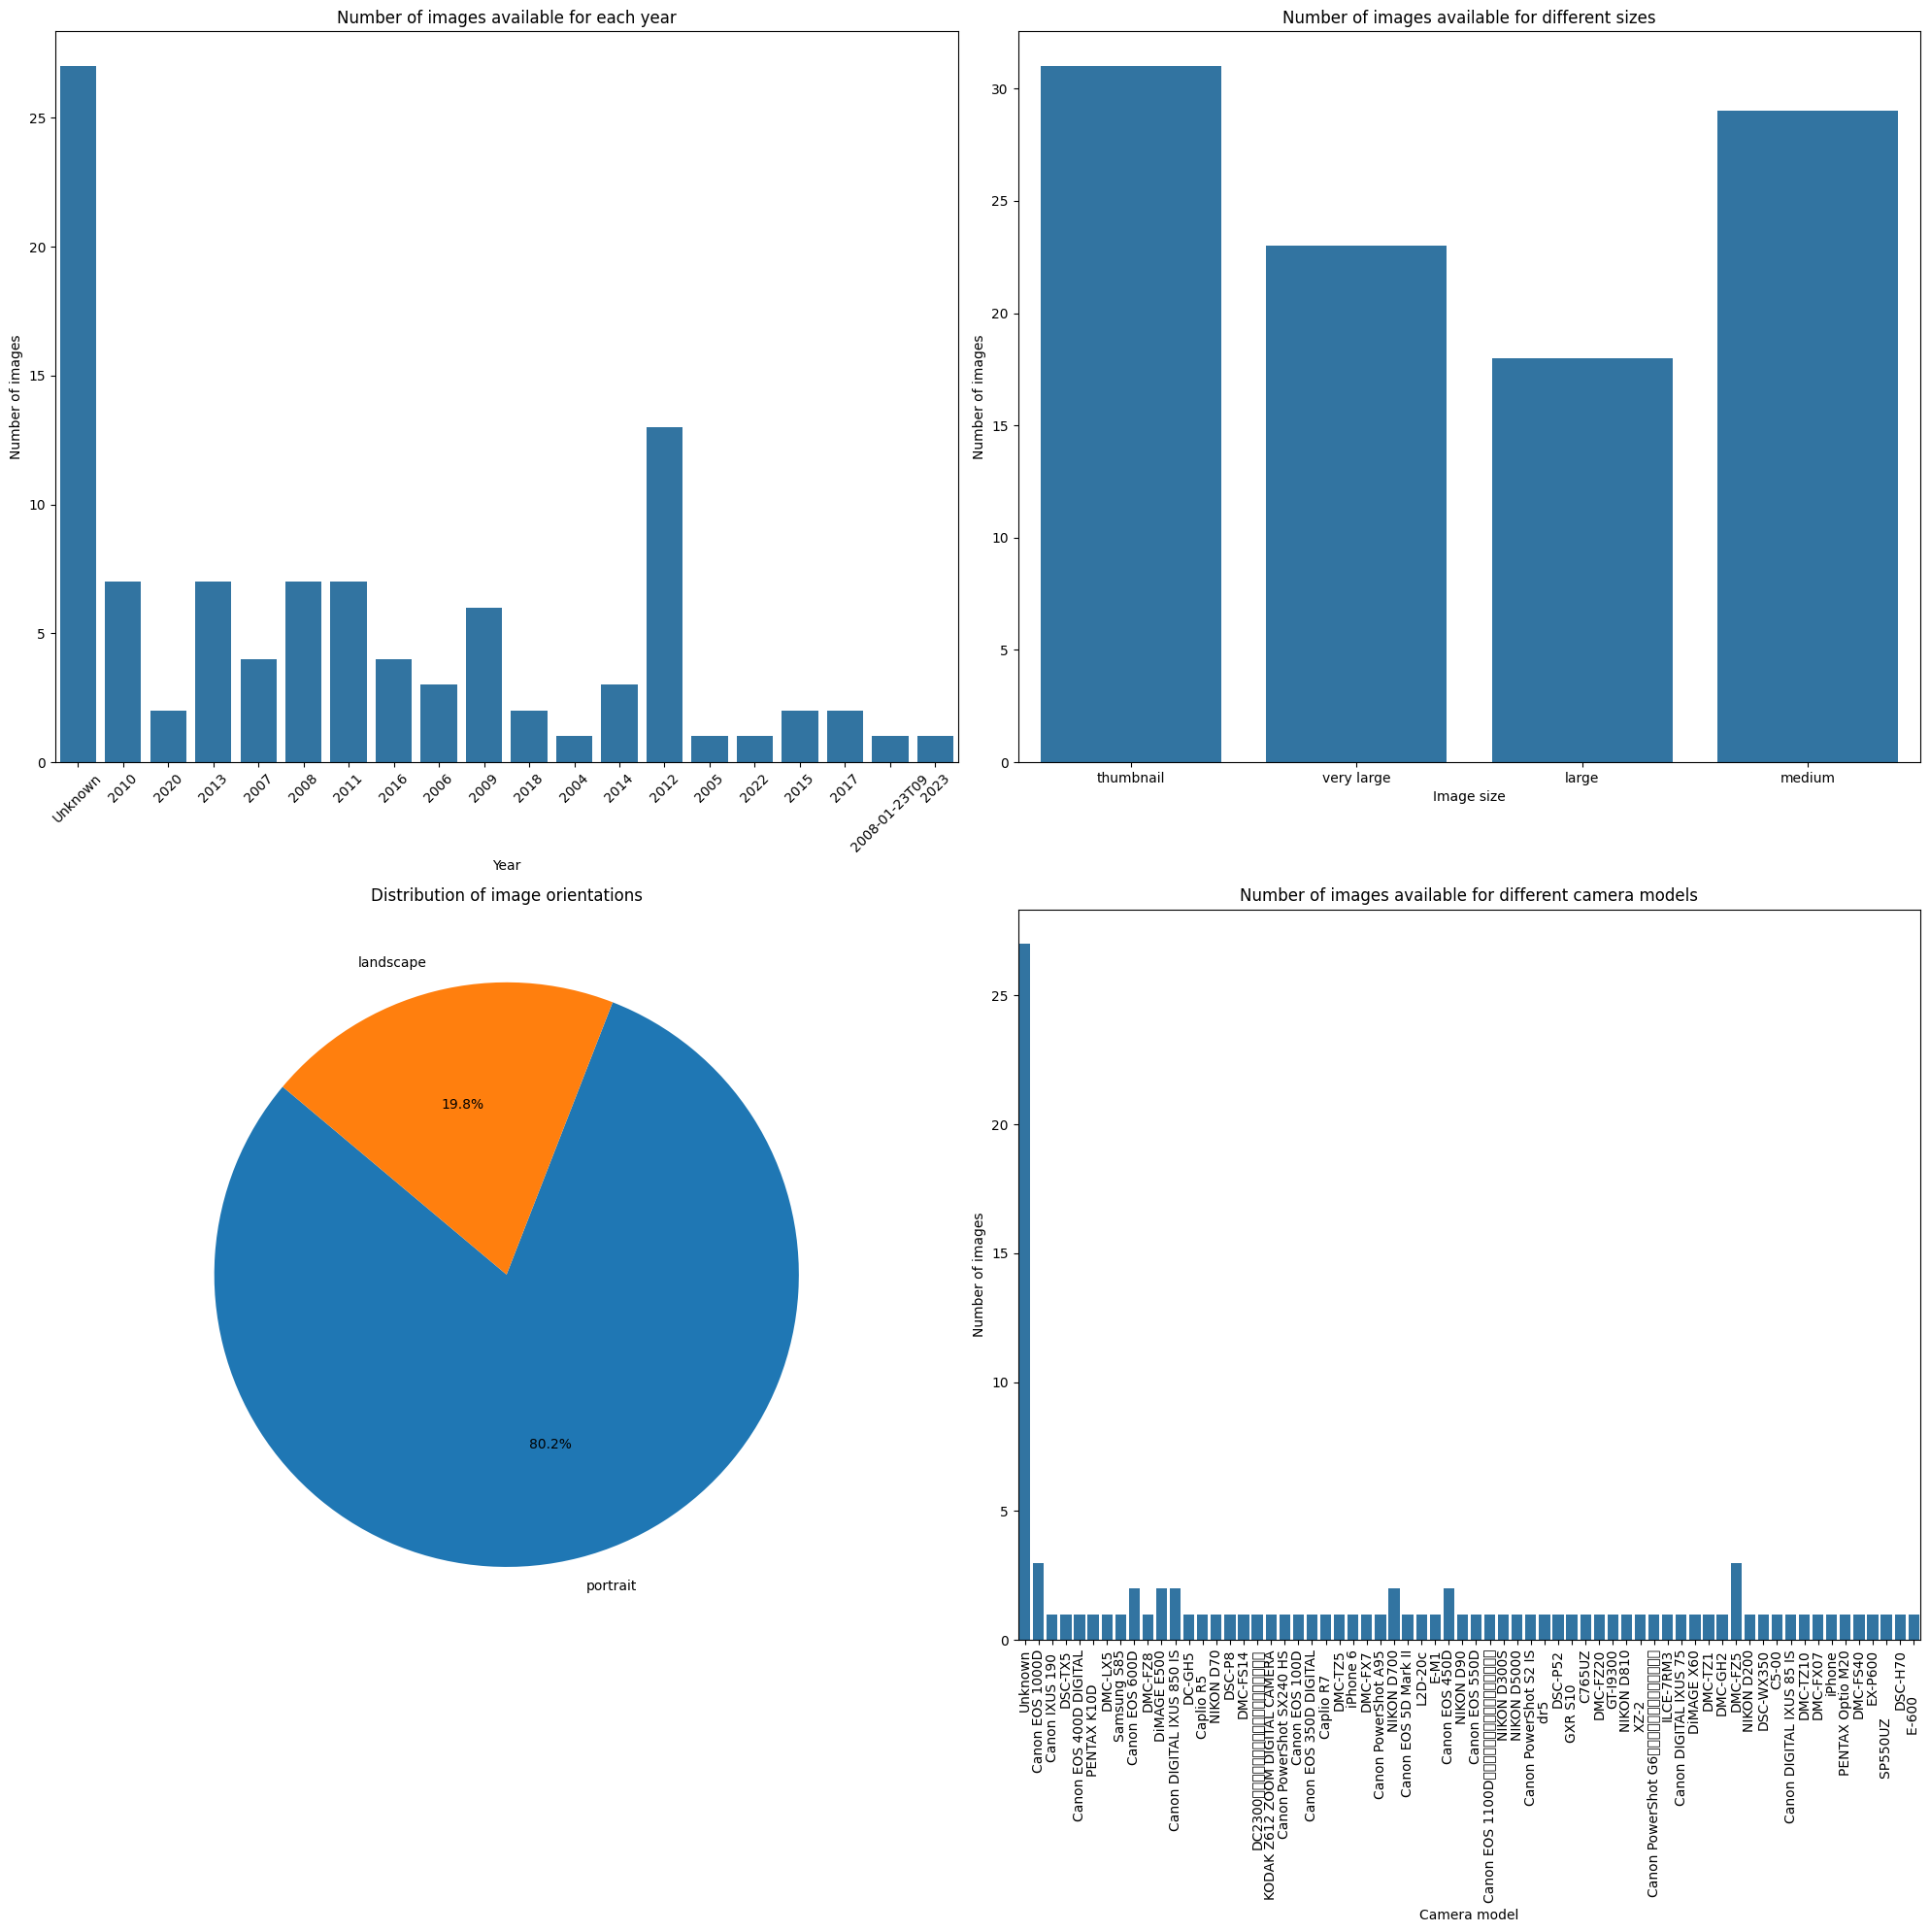

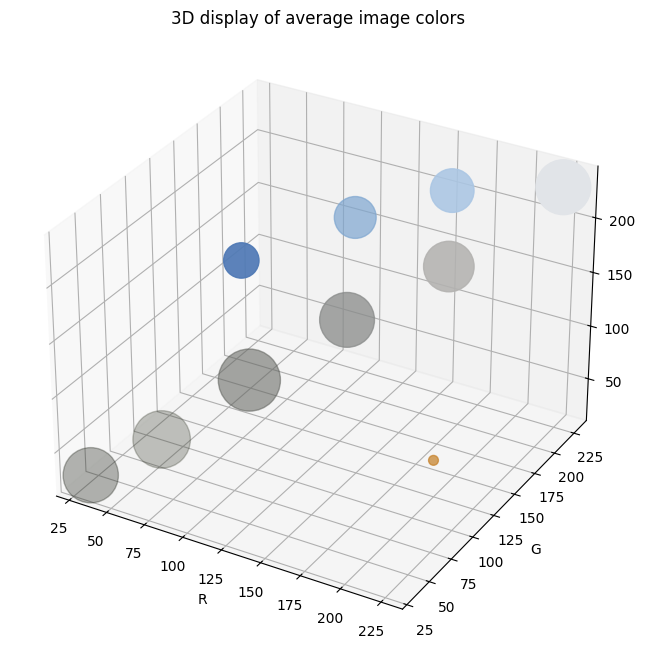

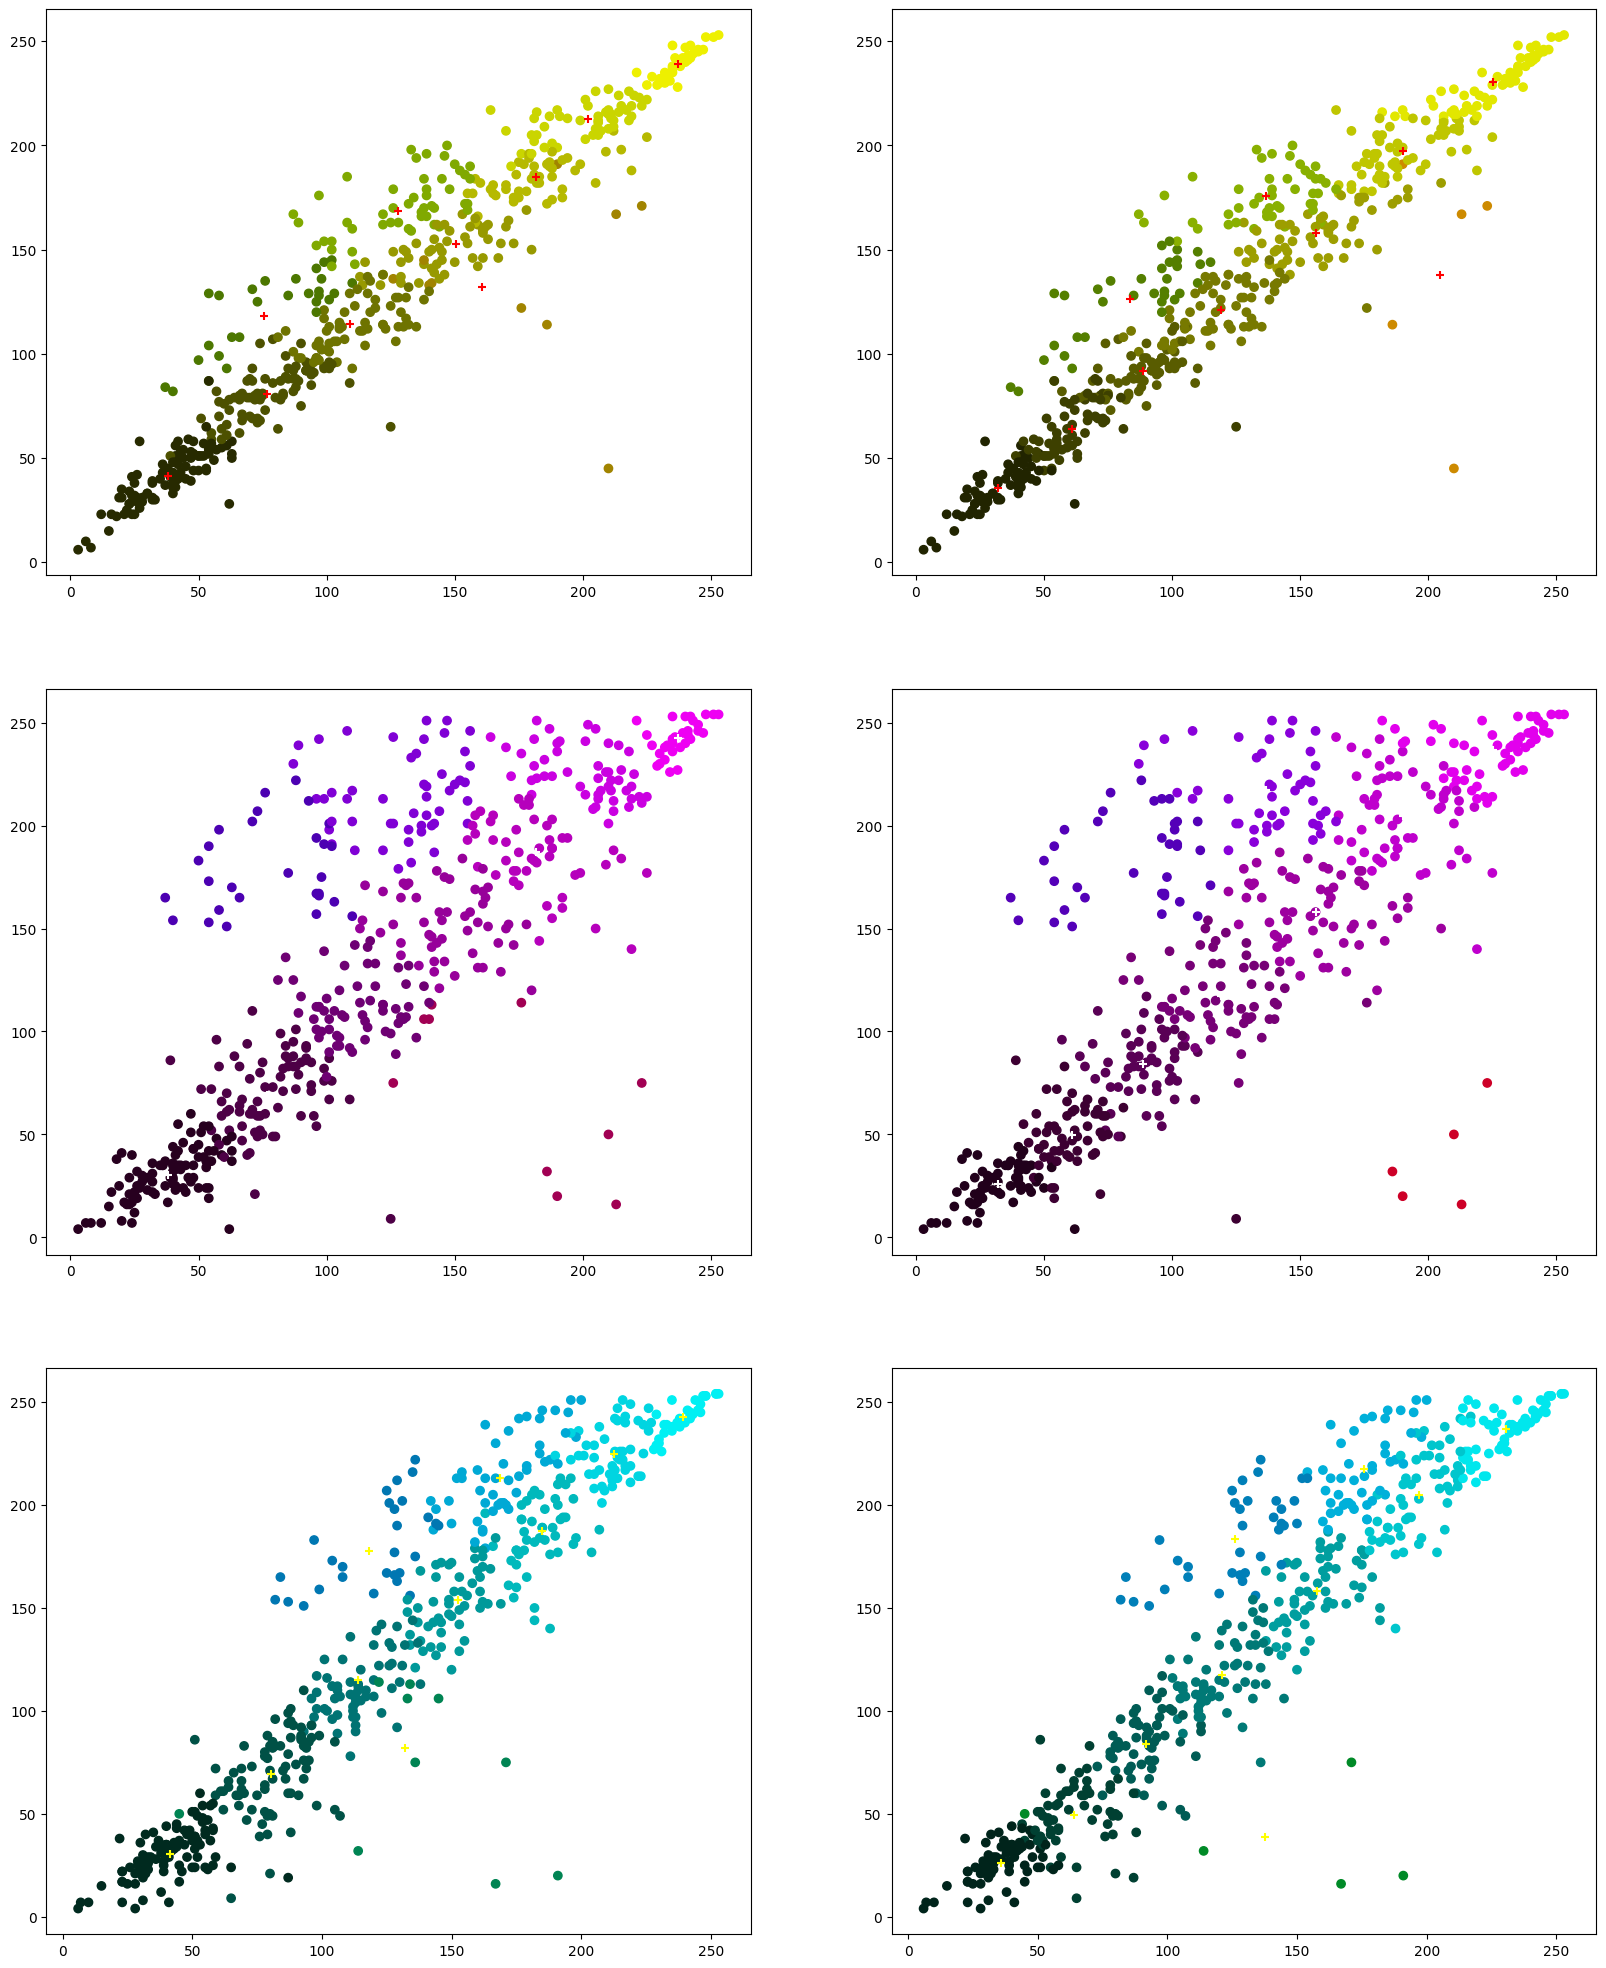

In [34]:
import seaborn as sns
from collections import Counter
import numpy as np
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, minmax_scale

with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)


def load_informations(image_metadata):
    # Number of images available for each year
    years = [img['exif'].get('DateTime', 'Unknown').split(':')[0] for img in image_metadata]
    year_counts = Counter(years)

    # Number of images available for different sizes
    sizes = [img['size'] for img in image_metadata]
    size_categories = ['thumbnail' if w * h < avg_size * 0.5 else 'medium' if w * h < avg_size else 'large' if w * h < avg_size * 1.5 else 'very large' for w, h in sizes]
    size_counts = Counter(size_categories)

    # Number of images available for different orientations
    orientations = [img['orientation'] for img in image_metadata]
    orientation_counts = Counter(orientations)

    # Number of images available for different camera models
    camera_models = [img['exif'].get('Model', 'Unknown') for img in image_metadata]
    camera_model_counts = Counter(camera_models)
    return year_counts, size_counts, orientation_counts, camera_model_counts

def display_grid(year_counts, size_counts, orientation_counts, camera_model_counts):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

    # Number of images available for each year
    sns.barplot(ax=axes[0, 0], x=list(year_counts.keys()), y=list(year_counts.values()))
    axes[0, 0].set_title('Number of images available for each year')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of images')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Number of images available for different sizes
    sns.barplot(ax=axes[0, 1], x=list(size_counts.keys()), y=list(size_counts.values()))
    axes[0, 1].set_title('Number of images available for different sizes')
    axes[0, 1].set_xlabel('Image size')
    axes[0, 1].set_ylabel('Number of images')

    # Number of images available for different orientations
    axes[1, 0].pie(orientation_counts.values(), labels=orientation_counts.keys(), autopct='%1.1f%%', startangle=140)
    axes[1, 0].set_title('Distribution of image orientations')

    # Number of images available for different camera models
    sns.barplot(ax=axes[1, 1], x=list(camera_model_counts.keys()), y=list(camera_model_counts.values()))
    axes[1, 1].set_title('Number of images available for different camera models')
    axes[1, 1].set_xlabel('Camera model')
    axes[1, 1].set_ylabel('Number of images')
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

year_counts, size_counts, orientation_counts, camera_model_counts = load_informations(image_metadata)
display_grid(year_counts, size_counts, orientation_counts, camera_model_counts)
def color_info(image_metadata, cluster_count=10):
    import matplotlib.pyplot as plt

    # Collect all colors from image metadata
    all_colors = [color for img in image_metadata for color in img['favorite_color']]
    all_colors = np.array(all_colors, dtype=np.uint8)

    # MiniBatchKMeans clustering
    mclusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    mclusters.fit(all_colors)

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))

    # Scatter plot for RG (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(mclusters.cluster_centers_[j][0]), math.ceil(mclusters.cluster_centers_[j][1]), 0) for j in mclusters.labels_]
    axes[0, 0].scatter(all_colors[:, 0], all_colors[:, 1], c=colors)
    axes[0, 0].scatter(mclusters.cluster_centers_[:, 0], mclusters.cluster_centers_[:, 1], marker="+", c="red")

    # Scatter plot for RB (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(mclusters.cluster_centers_[j][0]), 0, math.ceil(mclusters.cluster_centers_[j][2])) for j in mclusters.labels_]
    axes[1, 0].scatter(all_colors[:, 0], all_colors[:, 2], c=colors)
    axes[1, 0].scatter(mclusters.cluster_centers_[:, 0], mclusters.cluster_centers_[:, 2], marker="+", c="white")

    # Scatter plot for GB (RGB)
    colors = ["#%02x%02x%02x" % (0, math.ceil(mclusters.cluster_centers_[j][1]), math.ceil(mclusters.cluster_centers_[j][2])) for j in mclusters.labels_]
    axes[2, 0].scatter(all_colors[:, 1], all_colors[:, 2], c=colors)
    axes[2, 0].scatter(mclusters.cluster_centers_[:, 1], mclusters.cluster_centers_[:, 2], marker="+", c="yellow")

    # KMeans clustering
    clusters = KMeans(n_clusters=cluster_count, n_init=2)
    clusters.fit(all_colors)

    # Scatter plot for RG (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(clusters.cluster_centers_[j][0]), math.ceil(clusters.cluster_centers_[j][1]), 0) for j in clusters.labels_]
    axes[0, 1].scatter(all_colors[:, 0], all_colors[:, 1], c=colors)
    axes[0, 1].scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 1], marker="+", c="red")

    # Scatter plot for RB (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(clusters.cluster_centers_[j][0]), 0, math.ceil(clusters.cluster_centers_[j][2])) for j in clusters.labels_]
    axes[1, 1].scatter(all_colors[:, 0], all_colors[:, 2], c=colors)
    axes[1, 1].scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 2], marker="+", c="white")

    # Scatter plot for GB (RGB)
    colors = ["#%02x%02x%02x" % (0, math.ceil(clusters.cluster_centers_[j][1]), math.ceil(clusters.cluster_centers_[j][2])) for j in clusters.labels_]
    axes[2, 1].scatter(all_colors[:, 1], all_colors[:, 2], c=colors)
    axes[2, 1].scatter(clusters.cluster_centers_[:, 1], clusters.cluster_centers_[:, 2], marker="+", c="yellow")

    plt.show()

# 3D display of image averages
def display_3d(image_metadata, cluster_count=10):
    all_colors = [color for img in image_metadata for color in img['favorite_color']]
    all_colors = np.array(all_colors, dtype=np.uint8)

    clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    clusters.fit(all_colors)

    unique, frequency = np.unique(clusters.labels_, return_counts=True)
    scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

    colors = [
        "#%02x%02x%02x" % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2])
        ) for i in range(len(clusters.cluster_centers_))
    ]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        clusters.cluster_centers_[:, 0],
        clusters.cluster_centers_[:, 1],
        clusters.cluster_centers_[:, 2],
        c=colors,
        s=scaled_frequency
    )
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    plt.title('3D display of average image colors')
    plt.show()

display_3d(image_metadata)
color_info(image_metadata)


## Favorite data visualization

Information for user1:
Favorite images: ['Fernmeldeturm%20dortmund%20schwerte.jpg', 'Fernmeldeturm%20Hohe%20Wurzel%20%28Wiesbaden%29.jpg', 'Bautzen%20M%C3%BChlbastei%202.JPG', 'Fernmeldeturm%20Weilerskopf.jpg', 'Krynice%20%28maszt%29.jpg']
Favorite color: [121.11915250210829, 134.23986165287812, 136.775798456535]
Favorite orientation: portrait
Favorite size: thumbnail


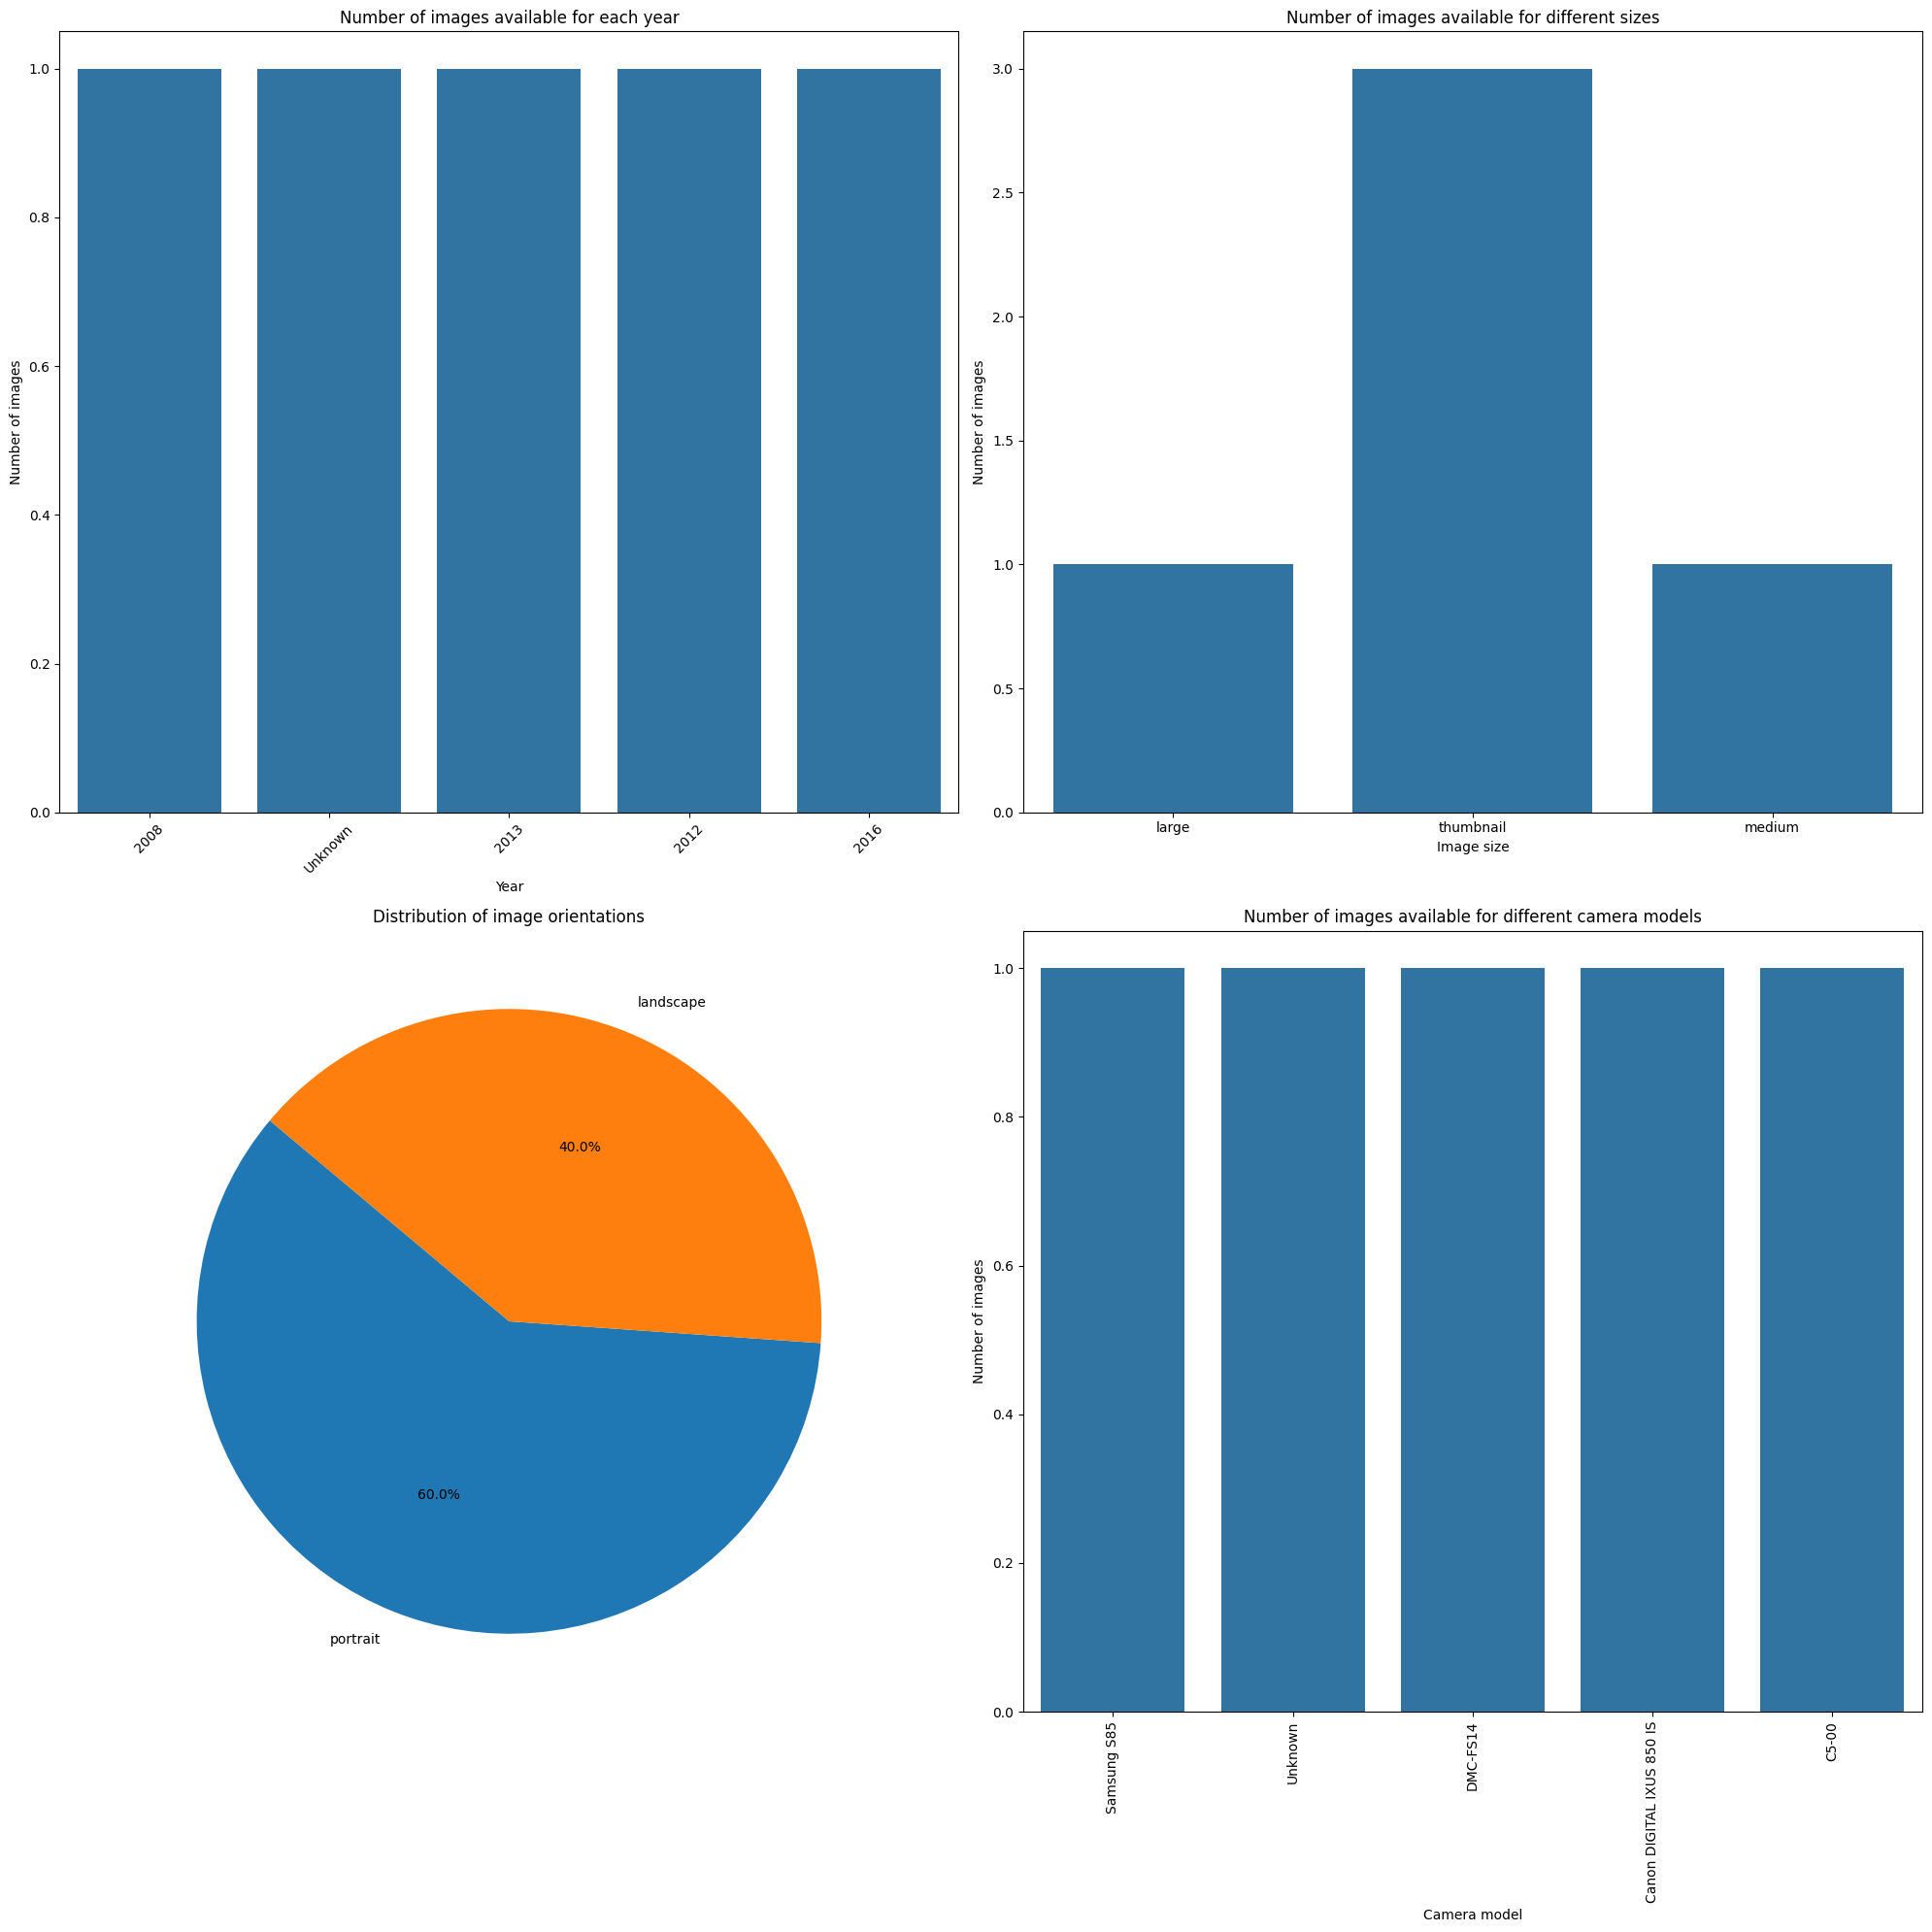

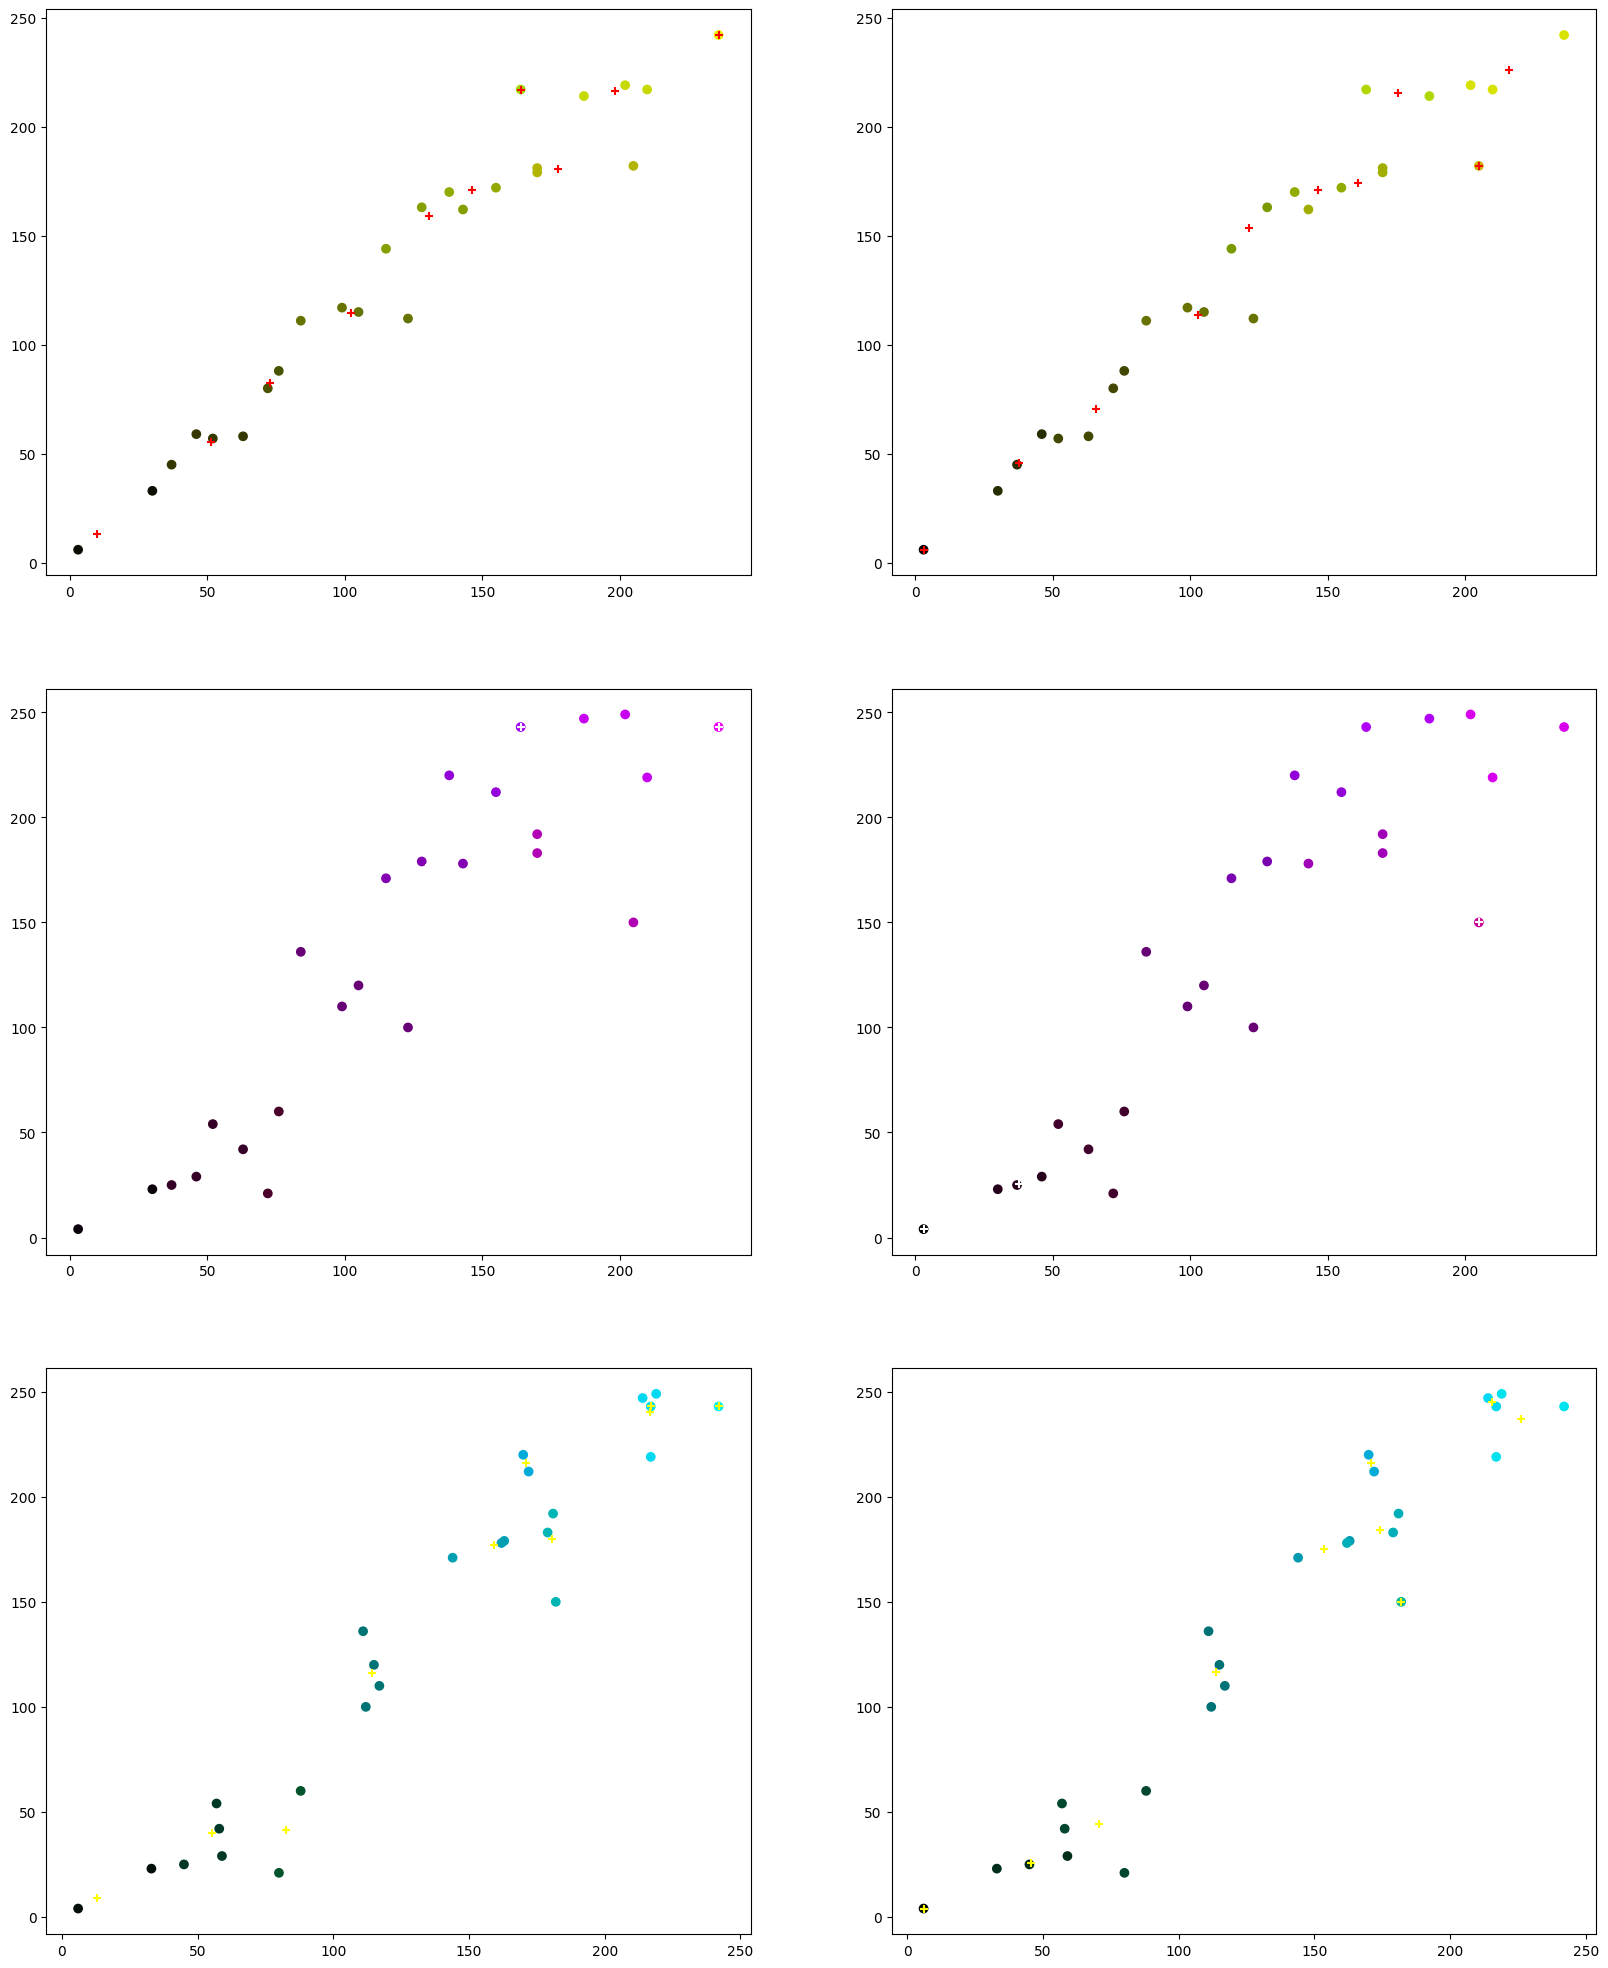

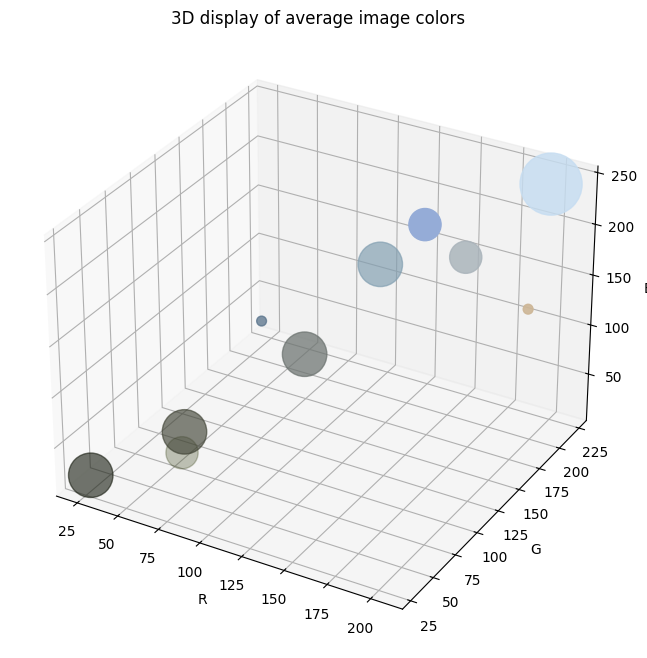

In [35]:
def display_user_info(user_id):
    # Load user data
    with open('json/users.json', 'r') as f:
        users_data = json.load(f)

    # Load image metadata
    with open('json/image_tags.json', 'r') as f:
        image_metadata = json.load(f)

    # Check if user exists
    if user_id not in users_data:
        print(f"User {user_id} does not exist.")
        return

    user_data = users_data[user_id]
    user_images = user_data['images']

    users_image_metadata = [img for img in image_metadata if img['filename'] in user_images]

    # Display user information
    print(f"Information for {user_id}:")
    print(f"Favorite images: {user_images}")
    print(f"Favorite color: {user_data['additional_info'].get('favorite_color', 'Not available')}")
    print(f"Favorite orientation: {user_data['additional_info'].get('orientation_favorite', 'Not available')}")
    print(f"Favorite size: {user_data['additional_info'].get('favorite_size', 'Not available')}")

    # Reset the variables corresponding to the photo information
    global year_counts, size_counts, orientation_counts, camera_model_counts
    
    year_counts, size_counts, orientation_counts, camera_model_counts = load_informations(users_image_metadata)
    display_grid(year_counts, size_counts, orientation_counts, camera_model_counts)
    color_info(users_image_metadata, cluster_count=10)
    display_3d(users_image_metadata, cluster_count=10)

# Display information for first 2 users
for i in range(1, 2):
    display_user_info(f'user{i}')

# Recommandations

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
from PIL import Image

# Load user data
with open('json/users.json', 'r') as f:
    users_data = json.load(f)

# Load image metadata
with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)

# Function to extract image features
def extract_features(image_data):
    features = []
    features.extend(image_data['favorite_color'][0])  # Use first favorite color as feature
    features.append(image_data['orientation_id'])
    features.append(image_data['size'][0] * image_data['size'][1])  # Use image size as feature
    return features

# Extract features for all images
image_features = {img['filename']: extract_features(img) for img in image_metadata}

# Function to create user profile
def create_user_profile(user_id):
    user_images = users_data[user_id]['images']
    user_features = [image_features[img] for img in user_images if img in image_features]
    if not user_features:
        return None
    user_profile = np.mean(user_features, axis=0)
    return user_profile

# Create profiles for all users
user_profiles = {user_id: create_user_profile(user_id) for user_id in users_data}

# Function to recommend images for a user
def recommend_images(user_id, top_n=5):
    if user_id not in users_data:
        print(f"User {user_id} does not exist.")
        return []

    user_profile = user_profiles[user_id]
    if user_profile is None:
        print(f"No image features found for user {user_id}.")
        return []

    # Calculate cosine similarity between user profile and all images
    all_image_features = np.array(list(image_features.values()))
    similarities = cosine_similarity(user_profile.reshape(1, -1), all_image_features).flatten()

    # Add impact from other users (collaborative filtering)
    for other_user_id, other_user_profile in user_profiles.items():
        if other_user_id != user_id and other_user_profile is not None:
            other_similarities = cosine_similarity(other_user_profile.reshape(1, -1), all_image_features).flatten()
            similarities += 0.1 * other_similarities  # Adjust weight of other users

    # Sort images by descending similarity
    sorted_indices = np.argsort(similarities)[::-1]

    # Get sorted image names
    sorted_images = np.array(list(image_features.keys()))[sorted_indices]

    # Exclude images already preferred by user
    user_images = users_data[user_id]['images']
    recommended_images = [img for img in sorted_images if img not in user_images]

    return recommended_images[:top_n]

# Example recommendation for user 1
user_id = 'user1'
recommended_images = recommend_images(user_id)
print(f"Recommended images for {user_id}: {recommended_images}")

Recommended images for user1: [np.str_('Freiherr-vom-Stein-Turm%20%28Hagen%29.jpg'), np.str_('Fernmeldeturm%20Wagh%C3%A4usel-Wiesental%20%282009%29.jpg'), np.str_('Habichtswald%20Fernmeldeturm.jpg'), np.str_('%C3%96denturm.jpg'), np.str_('Fernmeldeturm%20Hofkirchen.jpg')]


# Tests

Data Loading: OK
Loaded 5 users and 101 images
Metadata Validation: OK
All 101 images have complete metadata
Feature Extraction: OK
Features extracted for 101 images
User Profile Creation: OK
Created profiles for 5 users
Profile Validation: OK
All user profiles are properly formatted
Recommendations for user1: [np.str_('Fernmeldeturm%20Windischholzhausen.JPG'), np.str_('Roter%20Turm%20Crimmitschau.jpg'), np.str_('Habichtswald%20Fernmeldeturm.jpg'), np.str_('Fernmeldeturm%20Calau.jpg'), np.str_('Halle%20Sender%20Petersberg.JPG')]


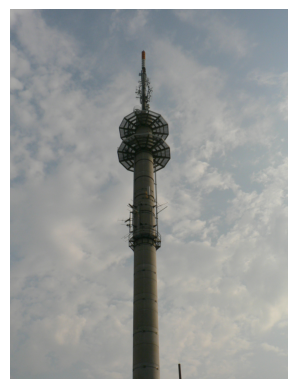

In [38]:
import json
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

# Load user data
def load_json(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"Error: {filename} is missing or corrupted.")
        return None

users_data = load_json('json/users.json')
image_metadata = load_json('json/image_tags.json')

# Debugging: Ensure data is loaded
if users_data is not None and image_metadata is not None:
    print("Data Loading: OK")
    print(f"Loaded {len(users_data)} users and {len(image_metadata)} images")

# Check the structure of metadata
def validate_metadata(image_metadata):
    errors = []
    for img in image_metadata:
        if 'filename' not in img:
            errors.append(f"Image missing filename: {img}")
        if 'size' not in img or len(img['size']) != 2:
            errors.append(f"Invalid size data for {img.get('filename', 'Unknown')}")
        if 'orientation_id' not in img:
            errors.append(f"Missing orientation_id for {img.get('filename', 'Unknown')}")
        if 'favorite_color' not in img or not img['favorite_color']:
            errors.append(f"Missing color data for {img.get('filename', 'Unknown')}")

    if errors:
        print("\nMetadata Errors Found:")
        for err in errors:
            print(f"- {err}")
    else:
        print("Metadata Validation: OK")
        print(f"All {len(image_metadata)} images have complete metadata")

validate_metadata(image_metadata)

# Extract features and validate
def extract_features(image_data):
    first_color = np.mean(image_data['favorite_color'][0]) if isinstance(image_data['favorite_color'][0], list) else image_data['favorite_color'][0]
    second_color = 0
    if len(image_data['favorite_color']) > 1:
        second_color = np.mean(image_data['favorite_color'][1]) if isinstance(image_data['favorite_color'][1], list) else image_data['favorite_color'][1]
    
    features = [
        first_color,
        second_color,
        image_data['orientation_id'],
        image_data['size'][0] * image_data['size'][1]
    ]
    return features

image_features = {img['filename']: extract_features(img) for img in image_metadata}

# Debugging: Check feature extraction
if len(image_features) > 0:
    print("Feature Extraction: OK")
    print(f"Features extracted for {len(image_features)} images")

# Create user profile and validate
def create_user_profile(user_id):
    if user_id not in users_data:
        return None
    
    user_images = users_data[user_id]['images']
    user_features = [image_features[img] for img in user_images if img in image_features]

    if not user_features:
        return None
    return np.mean(np.array(user_features), axis=0)

user_profiles = {user_id: create_user_profile(user_id) for user_id in users_data}

# Debugging: Check profile creation
if len(user_profiles) > 0:
    print("User Profile Creation: OK")
    print(f"Created profiles for {len(user_profiles)} users")

def validate_profiles():
    invalid_profiles = []
    for user_id, profile in user_profiles.items():
        if profile is None:
            invalid_profiles.append(f"User {user_id} has no valid profile")
        elif not isinstance(profile, np.ndarray):
            invalid_profiles.append(f"User {user_id} profile is incorrectly formatted")
    
    if invalid_profiles:
        print("\nProfile Validation Errors:")
        for err in invalid_profiles:
            print(f"- {err}")
    else:
        print("Profile Validation: OK")
        print("All user profiles are properly formatted")

validate_profiles()

# Recommendation system test
def test_recommendations(user_id, top_n=5):
    if user_id not in users_data:
        print(f"User {user_id} does not exist.")
        return []

    user_profile = user_profiles[user_id]
    if user_profile is None:
        print(f"No profile data for user {user_id}.")
        return []

    all_image_features = np.array(list(image_features.values()))
    similarities = cosine_similarity(user_profile.reshape(1, -1), all_image_features).flatten()
    
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_images = np.array(list(image_features.keys()))[sorted_indices]
    
    user_images = users_data[user_id]['images']
    recommended_images = [img for img in sorted_images if img not in user_images]

    return recommended_images[:top_n]

# Testing recommendations
test_user = "user1"
recommendations = test_recommendations(test_user)

# Debugging: Ensure recommendations are generated
assert recommendations is not None, "Recommendation system failed!"
print(f"Recommendations for {test_user}: {recommendations}")

# Visualization test (display recommended image)
def display_image(image_filename):
    image_path = os.path.join("images", image_filename)
    if not os.path.exists(image_path):
        print(f"Image {image_filename} not found.")
        return
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display first recommended image
if recommendations:
    display_image(recommendations[0])
